In [1]:
import tweepy
import datetime
import re
import pandas as pd 
import numpy as np 
import twint
import nest_asyncio
import spacy
import scipy.stats as sct
from langdetect import detect
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import matplotlib.pyplot as plt
nest_asyncio.apply()

# Extração dos Tweets da Avon

In [2]:
c = twint.Config()

In [3]:
nest_asyncio.apply()

# Extração dos dados no Período Pós BBB (25/01/2021 até 10/02/2021)

In [4]:
# Configure
c = twint.Config()
c.Search = "Avon"
c.Lang = "pt"
c.Pandas = True
c.Since = '2021-01-25'
c.Until = '2021-02-10'
twint.run.Search(c)

Tweets_df = twint.storage.panda.Tweets_df

02:10 -0300 <bevandton> @markneilson111 This is Headlands Beach park and that is the FairPort harbor light house.  You lived west of Cleveland? I live east of Cleveland.  I used to live in Elyria years ago which isn’t too far from Avon. How long has it been since you lived in Ohio?
1353523366762864643 2021-01-24 23:01:32 -0300 <BGsbeautycare> Be the first to get your hands on NEW Lumilayer Rosy Perfect Primer. Get a sneak peek trial size for just $7 with select VDL product purchases.   https://t.co/iv311YeKCE   #avon #vdl #new #lumilayer #rosy #perfectprimer #conditionsapply #brigittesbeautycare  https://t.co/aojc4LiZlD
1353522552648462337 2021-01-24 22:58:18 -0300 <JayTC07> @GriggsKidd41 Avon
1353522525679054848 2021-01-24 22:58:12 -0300 <LucySantos_004> @sophixeu @diarraluv @J_hoprigado @trybeherondale @mariartwork @vcutmi Esse eu comprei das revista Avon q minha vó vende N gosto muito de comprar de revista pq as capas n são tão boas, mas tava bem barato Eu nunca tinha visto o livro 

# Extração dos tweets pré BBB (08/01/2021 até 24/01/2021)

In [5]:
# Configure
c = twint.Config()
c.Search = "Avon"
c.Lang = "pt"
c.Pandas = True
c.Since = '2021-01-08'
c.Until = '2021-01-24'
twint.run.Search(c)

pre_bbb = twint.storage.panda.Tweets_df

008 2021-01-07 22:11:34 -0300 <JackieNestle> Avon Digital Catalog -  https://t.co/xLLJlktjoU
1347350003870650368 2021-01-07 22:10:48 -0300 <HillHamilton> #FF #peopleyoushouldfollow #Writerlift #FollowFriday @AlfonsoTortoise @AliceKayAuthor  @AliceLongaker @aliciabee @AliciaJAuthor @AliGLove @alioop326 @AlixKermes @allison_author @AllisonHawn @AllistarBanks @ban_sidhe @barb_avon @Baron1Irene  https://t.co/ZlFhbDs23p
1347349121376657411 2021-01-07 22:07:17 -0300 <barb_avon> @quineatal Thanks, Matthew.  When I'm mobile, I'll try that.
1347349092805058562 2021-01-07 22:07:10 -0300 <JB__Alcantara> Você conhecer a Avon?  Avontade que eu tenho de te dar uns bjos🤣
1347349011360047110 2021-01-07 22:06:51 -0300 <halo_scot> @CDAngeloAuthor @MelJ_Writes @lifelovelily22 @Johnldeboer @vernsanders @SunIslandMusic @cmramsburg @jgmacleodauthor @Galdrafodr @eleesha @LanaCwrites @barb_avon @ElanaMcdougall @CanvassartS @Wrix2 @Readerhal54 @CarolynRuffles @CordonRoma @DBCarterAuthor @silicasun @InkDisregar

# Limpeza dos tweets - Avon

### 1 - Junção dos dados pré e pós BBB

In [6]:
#União dos datasets e marcação do período
Tweets_df['pos_bbb'] = 1
pre_bbb['pos_bbb'] = 0

In [7]:
full_tweets = Tweets_df.append(pre_bbb)

In [8]:
full_tweets.shape

(84602, 39)

Temos ao todo 84602 tweets extraídos e 39 colunas

### 2 - Seleção de features

In [9]:
#listando as colunas
full_tweets.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'timezone', 'place',
       'tweet', 'language', 'hashtags', 'cashtags', 'user_id', 'user_id_str',
       'username', 'name', 'day', 'hour', 'link', 'urls', 'photos', 'video',
       'thumbnail', 'retweet', 'nlikes', 'nreplies', 'nretweets', 'quote_url',
       'search', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest', 'pos_bbb'],
      dtype='object')

In [10]:
#avaliando dados nulos
full_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84602 entries, 0 to 28642
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               84602 non-null  object 
 1   conversation_id  84602 non-null  object 
 2   created_at       84602 non-null  float64
 3   date             84602 non-null  object 
 4   timezone         84602 non-null  object 
 5   place            84602 non-null  object 
 6   tweet            84602 non-null  object 
 7   language         84602 non-null  object 
 8   hashtags         84602 non-null  object 
 9   cashtags         84602 non-null  object 
 10  user_id          84602 non-null  int64  
 11  user_id_str      84602 non-null  object 
 12  username         84602 non-null  object 
 13  name             84602 non-null  object 
 14  day              84602 non-null  int64  
 15  hour             84602 non-null  object 
 16  link             84602 non-null  object 
 17  urls        

In [11]:
columns = ['id', 'date', 'place',
       'tweet', 'language', 'hashtags', 'day', 'hour', 'nlikes', 'nreplies', 'nretweets',
       'search', 'pos_bbb']

In [12]:
#Seleção de colunas relevantes
ft_tweets = full_tweets[columns]

In [13]:
#validação de tweets duplicados
ft_tweets.id.duplicated().value_counts()

False    84602
Name: id, dtype: int64

Não existem tweets com o mesmo ID

In [14]:
#Avaliação da localidade dos tweets
ft_tweets.language.value_counts()

en     41825
pt     28099
es      5537
und     2456
fr      1568
tl       880
it       860
tr       517
in       509
de       459
ru       281
ja       272
nl       183
pl       145
ro       141
et       109
ur        96
fi        83
ht        76
ca        65
no        60
ar        57
hi        56
cs        37
sv        35
hu        25
cy        24
lv        22
sl        16
lt        15
el        15
vi        14
uk        14
ko        11
bg         7
is         7
eu         6
da         5
fa         5
zh         3
th         3
or         1
iw         1
sr         1
am         1
Name: language, dtype: int64

Boa parte dos tweets vieram com o idioma Inglês. Vamos explorar para avaliar se são relevantes ou vieram por engano.

In [16]:
ft_tweets.query("language == 'en'")['tweet']

0                        @asianwrld @FearVentureGGs ohh no
2        Congratulations to all you "People on the Move...
5        New 40 Yard Dash PR’s 2/8/21  Cooper McDannald...
11        The Avon. Stratford. ♥️  https://t.co/bFrgBosUoN
12                     @KingdomElla @equibal_m I claim it🙏
                               ...                        
28635    @PatrickIMcMahon @MarianSAnderson @RunRedMouse...
28636    @barb_avon Me too last week shifting in my cha...
28637                     @timotheehals YER DAD SELLS AVON
28640    @barb_avon Getting old is not for wimps that's...
28641           @barb_avon It's a tie and I feel your pain
Name: tweet, Length: 41825, dtype: object

Vamos tentar detectar se existe algum tweet que foi marcado no idioma inglês e que estão em Português.

In [17]:
ft_tweets.query("language == 'en'")

,id,date,place,tweet,language,hashtags,day,hour,nlikes,nreplies,nretweets,search,pos_bbb
0,1358928392947568641,2021-02-08 20:59:11,,@asianwrld @FearVentureGGs ohh no,en,[],1,20,0,1,0,Avon,1
2,1358928123857948673,2021-02-08 20:58:07,,"Congratulations to all you ""People on the Move...",en,"[4liferesearch, medifast, jeunesse, beautycoun...",1,20,2,0,1,Avon,1
5,1358927649834467329,2021-02-08 20:56:14,,New 40 Yard Dash PR’s 2/8/21 Cooper McDannald...,en,[],1,20,3,1,1,Avon,1
11,1358926652898762755,2021-02-08 20:52:16,,The Avon. Stratford. ♥️ https://t.co/bFrgBosUoN,en,[],1,20,3,0,0,Avon,1
12,1358926614789189634,2021-02-08 20:52:07,,@KingdomElla @equibal_m I claim it🙏,en,[],1,20,0,0,0,Avon,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28635,1347333570008899591,2021-01-07 21:05:29,,@PatrickIMcMahon @MarianSAnderson @RunRedMouse...,en,[],4,21,1,1,0,Avon,0
28636,1347333507102765056,2021-01-07 21:05:14,,@barb_avon Me too last week shifting in my cha...,en,[],4,21,0,1,0,Avon,0
28637,1347333315574038529,2021-01-07 21:04:29,,@timotheehals YER DAD SELLS AVON,en,[],4,21,0,1,0,Avon,0
28640,1347332615360024577,2021-01-07 21:01:42,,@barb_avon Getting old is not for wimps that's...,en,[],4,21,1,1,0,Avon,0


In [18]:
def try_detect(tweet):
    try:
        return detect(tweet)
    except:
        return 'not_detected'
en_tweets = ft_tweets.query("language == 'en'")
en_tweets['detected_lang'] = en_tweets.apply(lambda row : try_detect(row['tweet']),axis=1)

In [19]:
en_tweets.detected_lang.value_counts()

en              38913
de                550
nl                391
no                252
tl                226
af                195
fr                175
so                133
id                122
sv                114
ca                113
it                107
et                100
fi                 70
da                 62
cy                 47
tr                 36
es                 36
sl                 34
ro                 32
vi                 30
hu                 25
pt                 19
sw                  8
hr                  7
cs                  6
pl                  6
sk                  5
sq                  5
lt                  3
lv                  2
not_detected        1
Name: detected_lang, dtype: int64

In [20]:
en_tweets.query("detected_lang == 'pt'")

,id,date,place,tweet,language,hashtags,day,hour,nlikes,nreplies,nretweets,search,pos_bbb,detected_lang
2722,1358620310031900672,2021-02-08 00:34:58,,@dalidoisa Coach Avon just around da corner.,en,[],1,00,1,0,0,Avon,1,pt
12046,1357529378591289346,2021-02-05 00:20:00,,mood igual o do fake da avon,en,[],5,00,1,0,0,Avon,1,pt
12918,1357425622050603010,2021-02-04 17:27:42,"{'type': 'Point', 'coordinates': [-23.24650687...",At Work ! em Avon CD Cabreuva https://t.co/bS...,en,[],4,17,0,0,0,Avon,1,pt
16976,1356946044538523654,2021-02-03 09:42:02,,Postcard https://t.co/dvVUZtkMdS,en,[],3,09,4,0,0,Avon,1,pt
18488,1356732399464423424,2021-02-02 19:33:05,,@barb_avon So do I🤫😂❤️,en,[],2,19,1,0,0,Avon,1,pt
25359,1355836012136689664,2021-01-31 08:11:10,,@BCFC_Supporters NO NO NO NO NO NO NO NO NO NO...,en,[],7,08,0,0,0,Avon,1,pt
26222,1355656436693532675,2021-01-30 20:17:36,,@barb_avon Please do.,en,[],6,20,1,1,0,Avon,1,pt
31753,1354917350907252740,2021-01-28 19:20:44,,O Perfect Red da Gama True Colour da Avon htt...,en,[],4,19,0,0,0,Avon,1,pt
32364,1354858973615300609,2021-01-28 15:28:46,,juntes com avon,en,[],4,15,0,2,0,Avon,1,pt
33509,1354776753898737664,2021-01-28 10:02:03,,#promoção #oferta Petit Happy Bug - 50ml - Av...,en,"[promoção, oferta, beleza, saude]",4,10,0,0,0,Avon,1,pt


Tendo em vista o baixo volume de tweets detectados como PT, bem como o baixo engajamento em retweets e likes, os mesmos serão desconsiderados da análise

In [22]:
pt_tweets = ft_tweets.query("language == 'pt'")
pt_tweets.to_csv('output/pt_tweets.csv',index=False)

In [3]:
pt_tweets = pd.read_csv("output/pt_tweets.csv")

#### Verificação do total de dias que restaram após a remoção dos tweets em inglês.

In [4]:
pt_tweets['date'] = pd.to_datetime(pt_tweets['date'])

In [5]:
print(f"Total Dias Pós: {pt_tweets.query('pos_bbb == 1')['date'].max() - pt_tweets.query('pos_bbb == 1')['date'].min()}")
print(f"Total Dias Pré: {pt_tweets.query('pos_bbb == 0')['date'].max() - pt_tweets.query('pos_bbb == 0')['date'].min()}")

Total Dias Pós: 14 days 23:52:49
Total Dias Pré: 14 days 23:51:12


#### Após as elimitações dos tweets detectados em outros idiomas, vamos verificar quantos tweets temos nos períodos antes e após o início do programa.

In [6]:
pt_tweets.groupby('pos_bbb').agg(
    total=('id','count')
)

,total
pos_bbb,
0,2839
1,25260


#### Ao longo dos 14 dias antes do início do programa e nos 14 dias após, percebemos um grande aumento no volume de Tweets para a Avon, vamos explorar um pouco mais estes dados.

## 3 - Análise temporal 
### - Tweets por Dia

In [7]:
pt_tweets['dates'] = pt_tweets['date'].dt.date 

In [8]:
tweets_day = pt_tweets.groupby('dates').agg(
    tweets_dia=('id','count')
)

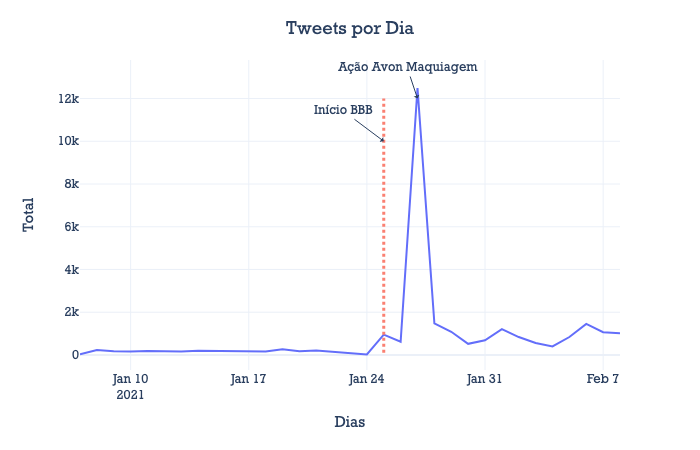

In [10]:
fig = px.line(tweets_day, template='plotly_white',labels={
    "dates" : "Dias",
    "value" : "Total"
})
fig.add_shape(
    type="line", line_color="salmon", line_width=3, opacity=1, line_dash="dot",
    x0='2021-01-25', x1='2021-01-25', y0=100, y1=12000
)
fig.update_layout( # customize font and legend orientation & position
    font_family="Rockwell",
    showlegend=False,
    title={
    'text' : 'Tweets por Dia',
    'y': 0.95,
    'x': 0.5
    }
)
fig.add_annotation(
    text="Ação Avon Maquiagem", x='2021-01-27', y=12000, arrowhead=1, showarrow=True
)
fig.add_annotation(
    text="Início BBB", x='2021-01-25', y=10000, arrowhead=1, showarrow=True,     
    ax=-40,
    ay=-30
)
fig.show('png')

Observamos aqui um pico no dia de maior exposição da marca, que segue-se por uma tendência de crescimento. Agora vamos analisar Likes e Retweets

In [11]:
likes_day = pt_tweets.groupby('dates').agg(
    tweets_dia=('nlikes','sum')
)

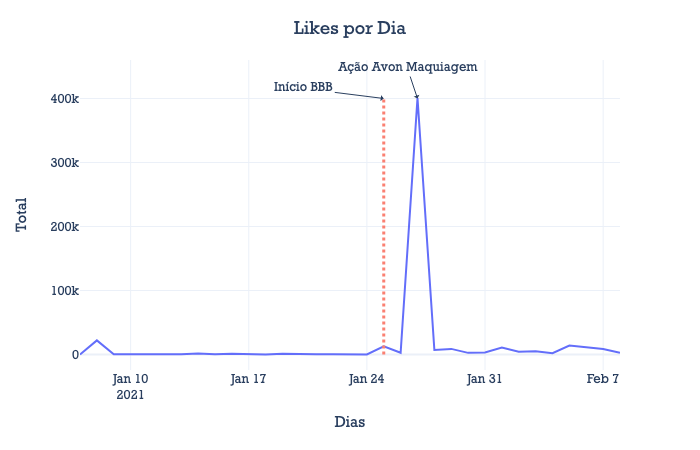

In [13]:
fig = px.line(likes_day, template='plotly_white',labels={
    "dates" : "Dias",
    "value" : "Total"
})
fig.add_shape(
    type="line", line_color="salmon", line_width=3, opacity=1, line_dash="dot",
    x0='2021-01-25', x1='2021-01-25', y0=100, y1=400000
)
fig.update_layout( # customize font and legend orientation & position
    font_family="Rockwell",
    showlegend=False,
    title={
    'text' : 'Likes por Dia',
    'y': 0.95,
    'x': 0.5
    }
)
fig.add_annotation(
    text="Ação Avon Maquiagem", x='2021-01-27', y=400000, arrowhead=1, showarrow=True
)
fig.add_annotation(
    text="Início BBB", x='2021-01-25', y=400000, arrowhead=1, showarrow=True,     
    ax=-80,
    ay=-10
)
fig.show('png')

In [14]:
retweets_day = pt_tweets.groupby('dates').agg(
    tweets_dia=('nretweets','sum')
)
retweets_day['day_log'] = np.log(retweets_day['tweets_dia'])

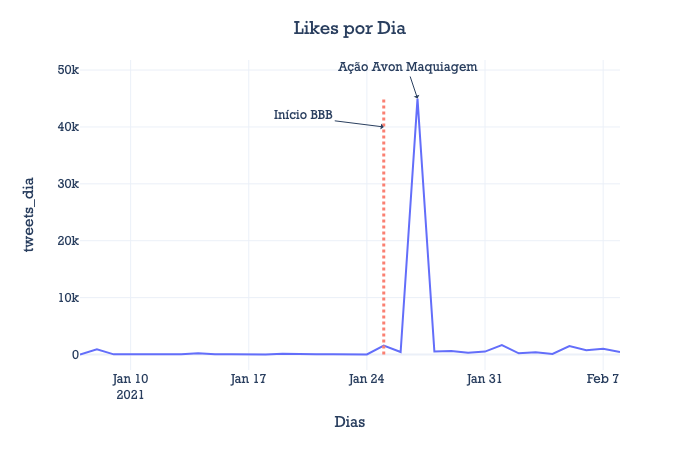

In [15]:
fig = px.line(retweets_day, y='tweets_dia', template='plotly_white',labels={
    "dates" : "Dias",
    "value" : "Total"
})
fig.add_shape(
    type="line", line_color="salmon", line_width=3, opacity=1, line_dash="dot",
    x0='2021-01-25', x1='2021-01-25', y0=0, y1=45000
)
fig.update_layout( # customize font and legend orientation & position
    font_family="Rockwell",
    showlegend=False,
    title={
    'text' : 'Likes por Dia',
    'y': 0.95,
    'x': 0.5
    }
)
fig.add_annotation(
    text="Ação Avon Maquiagem", x='2021-01-27', y=45000, arrowhead=1, showarrow=True
)
fig.add_annotation(
    text="Início BBB", x='2021-01-25', y=40000, arrowhead=1, showarrow=True,     
    ax=-80,
    ay=-10
)
fig.show('png')

Observando os gráficos, tanto o total de tweets, likes e retweets apresentam um pico no dia 27/01, onde a marca fez uma ação de divulgação dentro do programa. Porém, fica difícil saber se as médias destes indicadores apresentaram mudança significativa após este dia. 
Para avaliar este efeito, vamos utilizar um teste de hipótese

### - Teste de Hipótese Tweets por dia

$H_0$ : $\mu_0 = \mu_1$ a média antes do dia 25/01 é igual a após

$H_1$ : $\mu_0 \not= \mu_1$ a média antes do dia 25/01 é diferente a após

$p-valor = 0.05$

In [16]:
tweets_day = pt_tweets.groupby('dates').agg(
    tweets_dia=('id','count'),
    treatment=('pos_bbb','mean')
)
rt_day = pt_tweets.groupby('dates').agg(
    tweets_dia=('nretweets','sum'),
    treatment=('pos_bbb','mean')
)
lk_day = pt_tweets.groupby('dates').agg(
    tweets_dia=('nlikes','sum'),
    treatment=('pos_bbb','mean')
)
tweets_day.head()

,tweets_dia,treatment
dates,,
2021-01-07,38,0
2021-01-08,235,0
2021-01-09,180,0
2021-01-10,158,0
2021-01-11,182,0


In [17]:
#vamos avaliar a diferença simples entre médias
pre_bbb_m = tweets_day.query("treatment == 0")['tweets_dia'].mean()
pos_bbb_m = tweets_day.query("treatment == 1")['tweets_dia'].mean()
print(f"Pos_bbb - Pre_bbb = {pos_bbb_m - pre_bbb_m}")

Pos_bbb - Pre_bbb = 1401.3125


In [18]:
pre_bbb = tweets_day.query("treatment == 0")['tweets_dia']
pos_bbb = tweets_day.query("treatment == 1")['tweets_dia']

In [19]:
print(f"P-valor: {sct.ttest_ind(pos_bbb,pre_bbb,equal_var=False).pvalue}")

P-valor: 0.07553727653608655


Com as amostras apresentadas, a um nível de significância de 5% e de acordo com o p-valor obtido, nós não temos evidências suficientes para rejeitar a hipótese nula (média antes do programa ser igual à média após o programa). 

Vamos rodar o mesmo teste para likes e retweets.

In [20]:
#retweets
pre_bbb_rt = rt_day.query("treatment == 0")['tweets_dia']
pos_bbb_rt = rt_day.query("treatment == 1")['tweets_dia']
print(f"P-valor: {sct.ttest_ind(pos_bbb_rt,pre_bbb_rt,equal_var=False).pvalue}")

P-valor: 0.24756238719731144


In [21]:
pre_bbb_lk = lk_day.query("treatment == 0")['tweets_dia']
pos_bbb_lk = lk_day.query("treatment == 1")['tweets_dia']
print(f"P-valor: {sct.ttest_ind(pos_bbb_lk,pre_bbb_lk,equal_var=False).pvalue}")

P-valor: 0.25512171871807604


Assim como para o total de tweets, a um nível de significância de 5% e de acordo com o p-valor obtido, nós não temos evidências suficientes para rejeitar a hipótese nula (média antes do programa ser igual à média após o programa).

In [22]:
tweets_day['t_log'] = np.log(tweets_day.tweets_dia.values)


In [23]:
new_val = pd.DataFrame({'tweets_dia': tweets_day['tweets_dia'].mean()}, index=pd.to_datetime(['2021-01-23']).date)
lg_tweets = tweets_day[['tweets_dia']].append(new_val).sort_index()

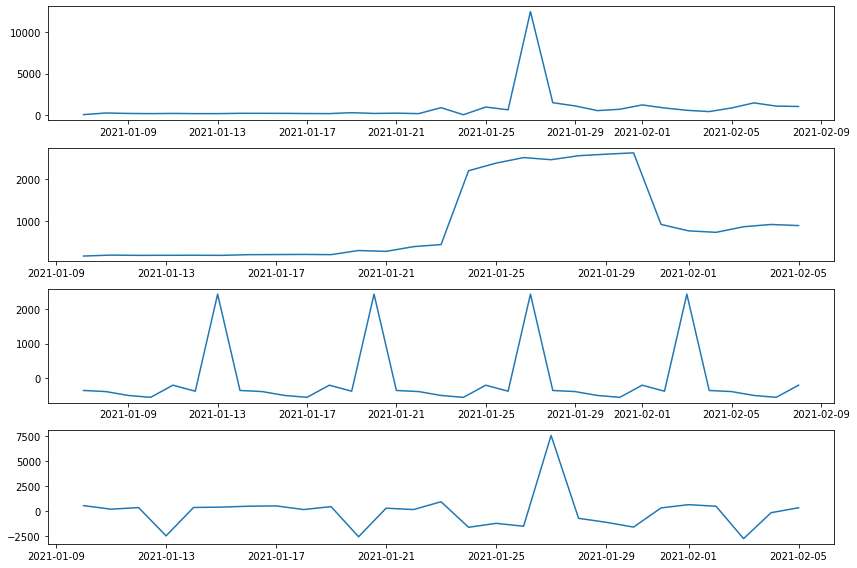

In [24]:
#decomposição da série temporal
result = seasonal_decompose(lg_tweets,model='additive',period=7)
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(12,8))
result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)
plt.tight_layout()